<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_6_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# snnTorch - Surrogate Gradient Descent in a Convolutional Spiking Neural Network
## Tutorial 6
### By Jason K. Eshraghian (www.jasoneshraghian.com)

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_6_CNN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". arXiv preprint arXiv:2109.12894, September 2021.](https://arxiv.org/abs/2109.12894) </cite>


# Introduction
In this tutorial, you will:
* Learn how to use surrogate gradient descent to overcome the dead neuron problem
* Construct and train a convolutional spiking neural network
* Use a sequential container, `nn.Sequential` to simplify model construction
* Use the `snn.backprop` module to reduce the time it takes to design a neural network

Part of this tutorial was inspired by Friedemann Zenke’s extensive
work on SNNs. Check out his repo on surrogate gradients
[here](https://github.com/fzenke/spytorch), and a favourite paper
of mine: E. O. Neftci, H. Mostafa, F. Zenke, [Surrogate Gradient
Learning in Spiking Neural Networks: Bringing the Power of
Gradient-based optimization to spiking neural
networks.](https://ieeexplore.ieee.org/document/8891809) IEEE
Signal Processing Magazine 36, 51–63.

At the end of the tutorial, we will train a convolutional spiking neural network (CSNN) using the MNIST dataset to perform image classification. The background theory follows on from [Tutorials 2, 4 and 5](https://snntorch.readthedocs.io/en/latest/tutorials/index.html), so feel free to go back if you need to brush up.

If running in Google Colab:
* You may connect to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`
* Next, install the latest PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

In [ ]:
!pip install snntorch

In [1]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

# 1. Surrogate Gradient Descent

[Tutorial 5](https://snntorch.readthedocs.io/en/latest/tutorials/index.html) raised the **dead neuron problem**. This arises because of the non-differentiability of spikes:


$$S[t] = \Theta(U[t] - U_{\rm thr}) \tag{1}$$ 
$$\frac{\partial S}{\partial U} = \delta(U - U_{\rm thr}) \in \{0, \infty\} \tag{2}$$ 

where $\Theta(\cdot)$ is the Heaviside step function, and $\delta(\cdot)$ is the Dirac-Delta function. We previously overcame this using the *Spike-Operator* approach, by assigning the spike to the derivative term: $\partial \tilde{S}/\partial U \leftarrow S \in \{0, 1\}$. Another approach is to smooth the Heaviside function during the backward pass, which correspondingly smooths out the gradient of the Heaviside function. 

Common smoothing functions include the sigmoid function, or the fast sigmoid function. The sigmoidal functions must also be shifted such that they are centered at the threshold $U_{\rm thr}$. Defining  the overdrive of the membrane potential as $U_{OD} = U - U_{\rm thr}$:

$$\tilde{S} = \frac{U_{OD}}{1+k|U_{OD}|} \tag{3}$$
$$\frac{\partial \tilde{S}}{\partial U} = \frac{1}{(k|U_{OD}|+1)^2}\tag{4}$$

where $k$ modulates how smooth the surrogate function is, and is treated as a hyperparameter. As $k$ increases, the approximation converges towards the original derivative in $(2)$:  

$$\frac{\partial \tilde{S}}{\partial U} \Bigg|_{k \rightarrow \infty} = \delta(U-U_{\rm thr})$$ 


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial6/surrogate.png?raw=true' width="800">
</center>

To summarize:

* **Forward Pass**
  - Determine $S$ using the shifted Heaviside function in $(1)$
  - Store $U$ for later use during the backward pass
* **Backward Pass**
  - Pass $U$ into $(4)$ to calculate the derivative term

In the same way the *Spike Operator* approach was used in [Tutorial 5](https://snntorch.readthedocs.io/en/latest/tutorials/index.html), 
the gradient of the fast sigmoid function can override the Dirac-Delta function in a Leaky Integrate-and-Fire
(LIF) neuron model:

In [2]:
# Leaky neuron model, overriding the backward pass with a custom function
class LeakySigmoidSurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0, k=25):
      super(Leaky_Surrogate, self).__init__()

      # initialize decay rate beta and threshold
      self.beta = beta
      self.threshold = threshold
      self.surrogate_func = self.FastSigmoid.apply
  
  # the forward function is called each time we call Leaky
  def forward(self, input_, mem):
    spk = self.surrogate_func((mem-self.threshold))  # call the Heaviside function
    reset = (spk - self.threshold).detach()
    mem = self.beta * mem + input_ - reset
    return spk, mem

  # Forward pass: Heaviside function
  # Backward pass: Override Dirac Delta with gradient of fast sigmoid
  @staticmethod
  class FastSigmoid(torch.autograd.Function):  
    @staticmethod
    def forward(ctx, mem, k=25):
        ctx.save_for_backward(mem) # store the membrane potential for use in the backward pass
        ctx.k = k
        out = (mem > 0).float() # Heaviside on the forward pass: Eq(1)
        return out

    @staticmethod
    def backward(ctx, grad_output): 
        (mem,) = ctx.saved_tensors  # retrieve membrane potential
        grad_input = grad_output.clone()
        grad = grad_input / (ctx.k * torch.abs(mem) + 1.0) ** 2  # gradient of fast sigmoid on backward pass: Eq(4)
        return grad, None

Better yet, all of that can be condensed by using the built-in module `snn.surrogate` from snnTorch, where $k$ from $(4)$ is denoted `slope`. The surrogate gradient is passed into `spike_grad` as an argument:

In [3]:
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5

lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)

To explore the other surrogate gradient functions available, [take a look at the documentation here.](https://snntorch.readthedocs.io/en/latest/snntorch.surrogate.html)

# 2. Setting up the CSNN
## 2.1 DataLoaders
Note that `utils.data_subset()` is called to reduce the size of the dataset by a factor of 10 to speed up training.

In [4]:
# dataloader arguments
batch_size = 128
data_path='/data/mnist'
subset=10

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# reduce datasets by 10x to speed up training
utils.data_subset(mnist_train, subset)
utils.data_subset(mnist_test, subset)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

## 2.2 Define the Network

The convolutional network architecture to be used is: 12C5-MP2-64C5-MP2-1024FC10

- 12C5 is a 5$\times$5 convolutional kernel with 12 filters
- MP2 is a 2$\times$2 max-pooling function
- 1024FC10 is a fully-connected layer that maps 1,024 neurons to 10 outputs

In [6]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
num_steps = 50

In [8]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.conv2 = nn.Conv2d(12, 64, 5)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc1 = nn.Linear(64*4*4, 10)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky() 
        mem3 = self.lif3.init_leaky()

        # Record the final layer
        spk3_rec = []
        mem3_rec = []

        for step in range(num_steps):
            cur1 = F.max_pool2d(self.conv1(x), 2)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = F.max_pool2d(self.conv2(spk1), 2)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc1(spk2.view(batch_size, -1))
            spk3, mem3 = self.lif3(cur3, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec), torch.stack(mem3_rec)

In the previous tutorial, the network was wrapped inside of a class, as shown above. 
With increasing network complexity, this adds a lot of boilerplate code that we might wish to avoid. Alternatively, the `nn.Sequential` method can be used instead:

In [9]:
#  Initialize Network
net = nn.Sequential(nn.Conv2d(1, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 64, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(64*4*4, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)


The `init_hidden` argument initializes the hidden states of the neuron (here, membrane potential). This takes place in the background as an instance variable. 
If `init_hidden` is activated, the membrane potential is not explicitly returned to the user, ensuring only the output spikes are sequentially passed through the layers wrapped in `nn.Sequential`. 

To train a model using the final layer's membrane potential, set the argument `output=True`. 
This enables the final layer to return both the spike and membrane potential response of the neuron.

## 2.3 Forward-Pass
A forward pass across a simulation duration of `num_steps` looks like this:

In [10]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

for step in range(num_steps):
    spk_out, mem_out = net(data)

Wrap that in a function, recording the membrane potential and spike response over time:

In [11]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)
  
  return torch.stack(spk_rec), torch.stack(mem_rec)

In [12]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

# 3. Training Loop

## 3.1 Loss Using snn.Functional

In the previous tutorial, the Cross Entropy Loss between the membrane potential of the output neurons and the target was used to train the network. 
This time, the total number of spikes from each neuron will be used to calculate the Cross Entropy instead.

A variety of loss functions are included in the `snn.functional` module, which is analogous to `torch.nn.functional` in PyTorch. 
These implement a mix of cross entropy and mean square error losses, are applied to spikes and/or membrane potential, to train a rate or latency-coded network. 

The approach below applies the cross entropy loss to the output spike count in order train a rate-coded network:

In [13]:
# already imported snntorch.functional as SF 
loss_fn = SF.ce_rate_loss()

The recordings of the spike are passed as the first argument to `loss_fn`, and the target neuron index as the second argument to generate a loss. [The documentation provides further information and exmaples.](https://snntorch.readthedocs.io/en/latest/snntorch.functional.html#snntorch.functional.ce_rate_loss)

In [14]:
loss_val = loss_fn(spk_rec, targets)

print(f"The loss from an untrained network is {loss_val.item():.3f}")

The loss from an untrained network is 2.303


## 3.2 Accuracy Using snn.Functional
The `SF.accuracy_rate()` function works similarly, in that the predicted output spikes and actual targets are supplied as arguments. `accuracy_rate` assumes a rate code is used to interpret the output by checking if the index of the neuron with the highest spike count matches the target index.

In [15]:
acc = SF.accuracy_rate(spk_rec, targets)

print(f"The accuracy of a single batch using an untrained network is {acc*100:.3f}%")

The accuracy of a single batch using an untrained network is 13.281%


As the above function only returns the accuracy of a single batch of data, the following function returns the accuracy on the entire DataLoader object:

In [16]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()
    
    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [17]:
test_acc = batch_accuracy(test_loader, net, num_steps)

print(f"The total accuracy on the test set is: {test_acc * 100:.2f}%")

The total accuracy on the test set is: 8.93%


## 3.3 Training Automation Using snn.backprop

Training SNNs can become arduous even with simple networks, so the `snn.backprop` module is here to reduce some of this effort.

The `backprop.BPTT` function automatically performs a single epoch of training, where you need only provide the training parameters, dataloader, and several other arguments. 
The average loss across iterations is returned. 
The argument `time_var` indicates whether the input data is time-varying. 
As we are using the MNIST dataset, we explicitly specify `time_var=False`. 

The following code block may take a while to run. If you are not connected to GPU, then consider reducing `num_epochs`.

In [18]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 10
test_acc_hist = []

# training loop
for epoch in range(num_epochs):

    avg_loss = backprop.BPTT(net, train_loader, optimizer=optimizer, criterion=loss_fn, 
                            num_steps=num_steps, time_var=False, device=device)
    
    print(f"Epoch {epoch}, Train Loss: {avg_loss.item():.2f}")

    # Test set accuracy
    test_acc = batch_accuracy(train_loader, net, num_steps)
    test_acc_hist.append(test_acc)

    print(f"Epoch {epoch}, Test Acc: {test_acc * 100:.2f}%\n")

Epoch 0, Train Loss: 1.78
Epoch 0, Test Acc: 92.24%

Epoch 1, Train Loss: 1.53
Epoch 1, Test Acc: 96.60%

Epoch 2, Train Loss: 1.50
Epoch 2, Test Acc: 97.30%

Epoch 3, Train Loss: 1.50
Epoch 3, Test Acc: 96.99%

Epoch 4, Train Loss: 1.49
Epoch 4, Test Acc: 97.45%

Epoch 5, Train Loss: 1.49
Epoch 5, Test Acc: 98.44%

Epoch 6, Train Loss: 1.48
Epoch 6, Test Acc: 98.32%

Epoch 7, Train Loss: 1.48
Epoch 7, Test Acc: 98.17%

Epoch 8, Train Loss: 1.48
Epoch 8, Test Acc: 98.10%

Epoch 9, Train Loss: 1.48
Epoch 9, Test Acc: 98.68%



Despite having selected some fairly generic values and architectures, the test set accuracy should be fairly competitive given the brief training run!

# 4. Results
## 4.1 Plot Test Accuracy

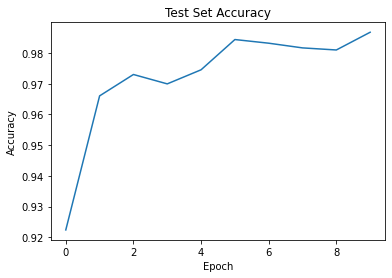

In [19]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## 4.2 Spike Counter

Run a forward pass on a batch of data to obtain spike and membrane readings.

In [20]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

Changing `idx` allows you to index into various samples from the simulated minibatch. Use `splt.spike_count` to explore the spiking behaviour of a few different samples!

> Note: if you are running the notebook locally on your desktop, please uncomment the line below and modify the path to your ffmpeg.exe



The target label is: 8


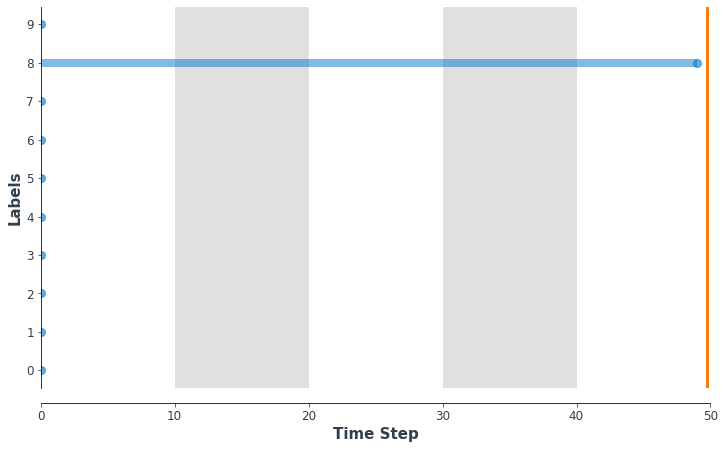

In [21]:
from IPython.display import HTML

idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels, 
                        animate=True, interpolate=4)

HTML(anim.to_jshtml())
# anim.save("spike_bar.mp4")

# Conclusion
You should now have a grasp of the basic features of snnTorch and be able to start running your own experiments. [In the next tutorial](https://snntorch.readthedocs.io/en/latest/tutorials/index.html), we will train a network using a neuromorphic dataset.


# Additional Resources
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)